In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchinfo import summary
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = '/kaggle/input/plantvillage-dataset/segmented'
print(data_dir)

/kaggle/input/plantvillage-dataset/segmented


In [4]:
image_datasets = datasets.ImageFolder(root=data_dir)
class_names = image_datasets.classes
print(f'Number of Classes: {len(class_names)}\nData set class names: \n{class_names}')

Number of Classes: 38
Data set class names: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

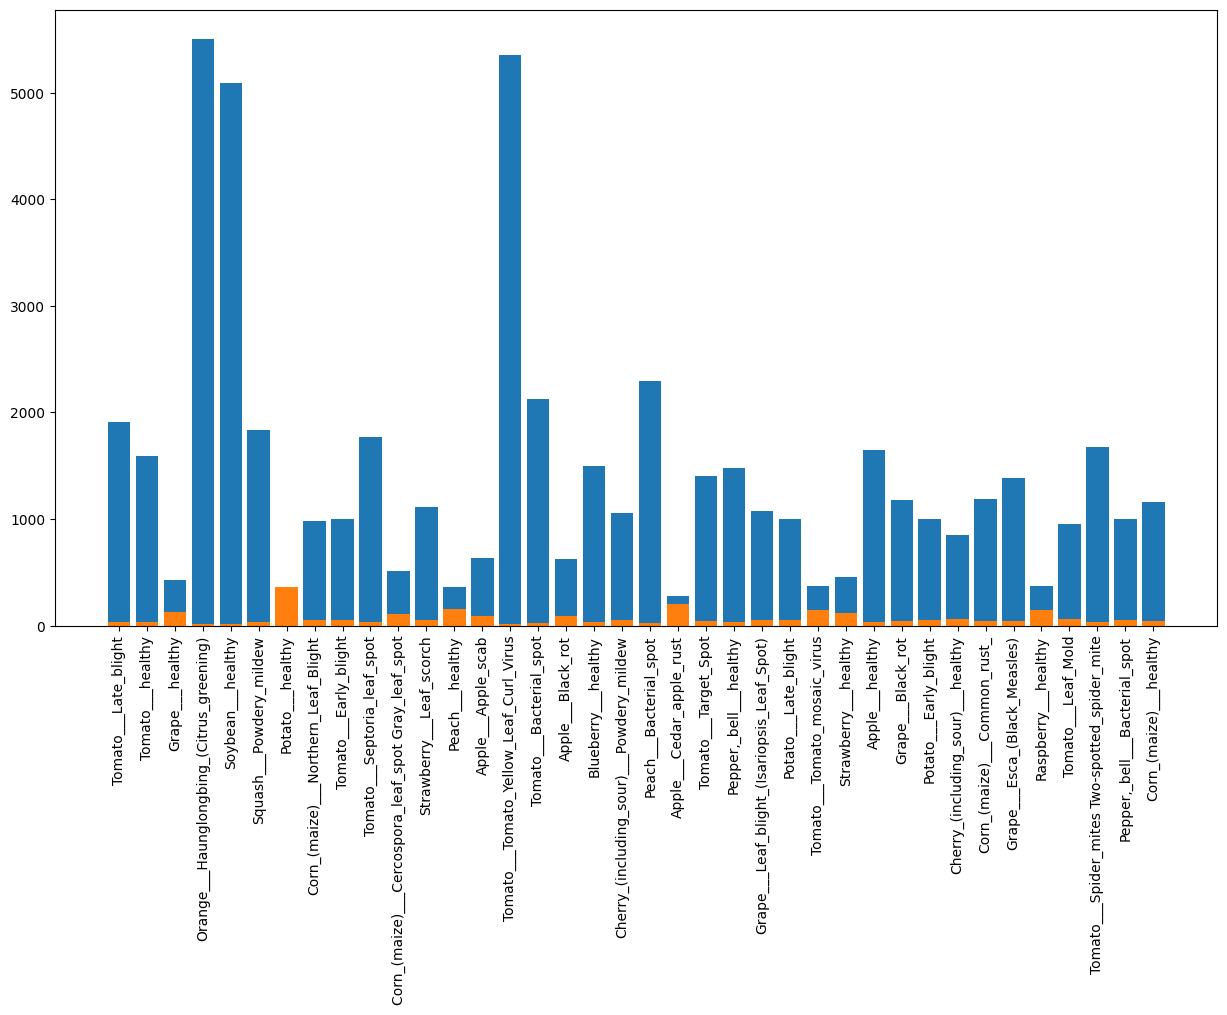

In [34]:
name = []
data_count = []
class_weights = []
total_data = len(image_datasets)
for class_name in os.listdir(data_dir):
	
	all_classes = os.path.join(data_dir, class_name)
	class_len = len(os.listdir(all_classes))
	name.append(class_name)
	data_count.append(class_len)
	weight = (class_len / total_data)
	class_weights.append(weight)
	# print (f"{class_name} --> {class_len}")
plt.figure(figsize=(15,8))
plt.bar(name, data_count)
plt.bar(name, 1/np.array(class_weights))
plt.xticks(name, name, rotation='vertical')
plt.show()
class_weights = torch.FloatTensor(class_weights).to(device)
# torch.sum(class_weights)

In [35]:
train, val, test = torch.utils.data.random_split(image_datasets, [0.8, 0.1, 0.1])
print(f'No of train: {len(train)} | No of val: {len(val)} | No of test: {len(test)} | ')

No of train: 43445 | No of val: 5431 | No of test: 5430 | 


In [36]:
# data transforms
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
data_transformer = {
	'train':
		transforms.Compose([
		transforms.RandomResizedCrop(248),
		transforms.RandomHorizontalFlip(),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	]),
	'val':
		transforms.Compose([
		transforms.CenterCrop(248),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	])
}

In [37]:
transform = transforms.ToTensor()
class PlantVillageDataset(Dataset):
	def __init__(self, datasets, transform=None):
		self.dataset = datasets
		self.transform = transform
		
	def __getitem__(self, index):
		if self.transform:
			x = self.transform(self.dataset[index][0])
		else:
			x = self.dataset[index][0]
		y = self.dataset[index][1]
		return x, y

	def __len__(self):
		return len(self.dataset)

In [4]:
class PlantNet(nn.Module):
	def __init__(self, model, num_classes):
		super(PlantNet, self).__init__()
		self.model = model
		for param in model.parameters():
			param.requires_grad = False

		self.n_features = self.model.fc.in_features
		self.n_classes = num_classes
		self.sequential = nn.Sequential(
			nn.Linear(self.n_features, 256),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(256, 128),
			nn.ReLU(),
			nn.Dropout(0.1),
			nn.Linear(128, self.n_classes) 
		)

			
	def forward(self, x):
		out = self.sequential(x)
		return out


model = PlantNet(models.resnet50(), 38)
# model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)
print(summary(model))

Layer (type:depth-idx)                        Param #
PlantNet                                      --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   (75,008)
│    │    └─Bottleneck: 3-2                   (70,400)
│    │    └─Bottleneck: 3-3                   (70,400)
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   (379,392)
│    │    └─Bottleneck: 3-5                   (280,064)
│    │    └─Bottleneck: 3-6                   (280,064)
│    │    └─Bottleneck: 3-7                   (280,064)
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   (1,512,448)
│    │    └─Bottleneck: 3-9                   (1,1

In [39]:
class FocalLoss(nn.Module):
	def __init__(self, alpha=None, gamma=2):
		super(FocalLoss, self).__init__()
		self.alpha = alpha
		self.gamma = gamma

	def forward(self, inputs, targets):
		ce_loss = F.cross_entropy(inputs, targets, reduction='none')
		pt = torch.exp(-ce_loss)
		loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
		return loss

In [48]:
#hyperparameters
n_classes = 38
n_epochs = 5
batch_size = 128
learning_rate = 0.01


In [50]:
train_data = PlantVillageDataset(train, data_transformer['train'])
val_data = PlantVillageDataset(val, data_transformer['val'])
test_data = PlantVillageDataset(test, transform)

In [51]:
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Loss and optimizer
criterion = FocalLoss(alpha=class_weights, gamma=2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# Training loop
start_time = time.time()
n_total_steps = len(train_data_loader)
losses = []
print(f'\n {"="*30}')
for epoch in range(n_epochs):
	for i, (images, labels) in enumerate(train_data_loader):
		images = images.to(device)
		labels = labels.to(device)
		
		#forward
		outputs = model(images)
		loss = criterion(outputs, labels)
		#backward
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
	# if(epoch + 1) % 10 == 0:
	losses.append(loss.item())
	print(f'| Epoch: {epoch+1}/{n_epochs}\t| Loss: {loss.item():.4f} |')
print(f' {"="*30}\n')
end_time = time.time() - start_time
#test
with torch.no_grad():
	n_correct = 0
	n_samples = 0
	for images, labels in test_data_loader:
		images = images.to(device)
		labels = labels.to(device)
		outputs = model(images)
		
		_, predictions = torch.max(outputs, 1)
		n_samples += labels.shape[0]
		n_correct += (predictions == labels).sum().item()
	accuracy = n_correct * 100.0 / n_samples
	print(f'\tAccuracy: {accuracy:.2f}%')
print(f'\n {"="*30}\n')
print(f'  Training Time: {end_time/60:.2f} Minute(s)')
print(f'\n {"="*30}\n')
plt.plot(losses)
plt.show()